In [255]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import pandas as pd
from scipy.ndimage import gaussian_filter1d
from scipy.optimize import curve_fit
import scipy as sp

In [256]:
class LorentzianDataset(Dataset):
    def __init__(self, x, y):
        self.x = torch.tensor(x, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)

    def __len__(self):
        return len(self.x)

    def __getitem__(self, idx):
        return self.x[idx], self.y[idx]

In [257]:
def gaussian(x, amp, mean, stddev, offset):
    return amp * np.exp(-((x - mean) ** 2) / (2 * stddev**2)) + offset


def rescale_data(data):
    """Rescales a numpy array to the range [0, 1]."""
    min_val = np.min(data)
    max_val = np.max(data)
    range_val = max_val - min_val
    if range_val == 0:
        return np.zeros_like(data)
    else:
        return (data - min_val) / range_val


def fit_gaussian_with_interpolation(y_data, gap=100):
    x_data = np.arange(len(y_data))
    y_data_rescaled = rescale_data(y_data)
    y_data_rescaled = gaussian_filter1d(y_data_rescaled, sigma=1)

    # Define indices for the interpolation points (start-1, midpoint, end-1 of the gap)
    idx_p1 = gap - 1  # Index before the start of the middle section
    idx_p3 = len(x_data) - gap  # Index at the start of the end section
    idx_p2 = np.argmin(y_data_rescaled)  # Index of the minimum value
    # Ensure indices are valid
    if not (
        0 <= idx_p1 < len(x_data)
        and 0 <= idx_p3 < len(x_data)
        and 0 <= idx_p2 < len(x_data)
    ):
        raise ValueError("Gap size is too large for the given data length.")
    if idx_p1 >= idx_p3:
        raise ValueError(
            "Gap size results in overlapping or invalid interpolation points."
        )

    # Get the x and y values for the three points needed for quadratic interpolation
    # Using points just before the gap, the last point, and the first point after the gap
    x_interp = x_data[[idx_p1, idx_p2, idx_p3]]
    y_interp = y_data_rescaled[[idx_p1, idx_p2, idx_p3]]

    # Create the quadratic interpolation function using scipy.interpolate.interp1d
    # Use points surrounding the gap for interpolation
    f_quad = sp.interpolate.interp1d(
        x_interp, y_interp, kind="linear", bounds_error=False, fill_value="extrapolate"
    )

    # Define the x values for the section to be interpolated
    x_middle = x_data[gap:-gap]
    if len(x_middle) == 0:
        raise ValueError("Gap size is too large, leaving no middle section.")

    y_interpolated = f_quad(x_middle)

    # Construct the y_data_fit array by concatenating the parts:
    y_data_fit = np.concatenate(
        (y_data_rescaled[:gap], y_interpolated, y_data_rescaled[-gap:])
    )

    # Ensure y_data_fit has the same length as x_data
    if len(y_data_fit) != len(x_data):
        num_middle_points = len(x_data) - 2 * gap
        x_middle = x_data[gap : gap + num_middle_points]
        y_interpolated = f_quad(x_middle)
        y_data_fit = np.concatenate(
            (y_data_rescaled[:gap], y_interpolated, y_data_rescaled[-gap:])
        )

        # Final check
        if len(y_data_fit) != len(x_data):
            raise ValueError(
                f"Constructed y_data_fit length ({len(y_data_fit)}) does not match x_data length ({len(x_data)}). Check gap and slicing logic."
            )

    bounds = (
        [-np.inf, -np.inf, 0, -np.inf],
        [0, np.inf, np.inf, np.inf],
    )  # Assuming negative amplitude, stddev > 0
    sigma = np.ones_like(y_data_fit)
    sigma[[0, gap, idx_p2, -gap, -1]] = 0.01
    try:
        popt, pcov = curve_fit(
            gaussian,
            x_data,
            y_data_fit,
            p0=[-1, np.mean(x_data), np.std(x_data), np.min(y_data_fit)],
            bounds=bounds,
            sigma=sigma,
        )
    except RuntimeError as e:
        print(f"Curve fitting failed: {e}")
        try:
            print("Retrying fit without bounds...")
            popt, pcov = curve_fit(
                gaussian,
                x_data,
                y_data_fit,
                p0=[-1, np.mean(x_data), np.std(x_data), np.min(y_data_fit)],
                sigma=sigma,
            )
        except Exception as e2:
            print(f"Curve fitting failed on retry: {e2}")
            popt, pcov = None, None  # Indicate failure

    return popt, y_data_rescaled

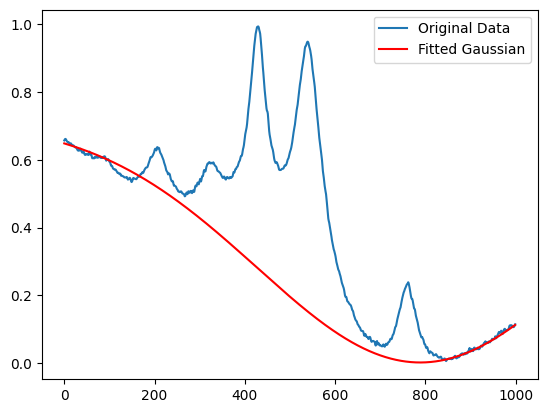

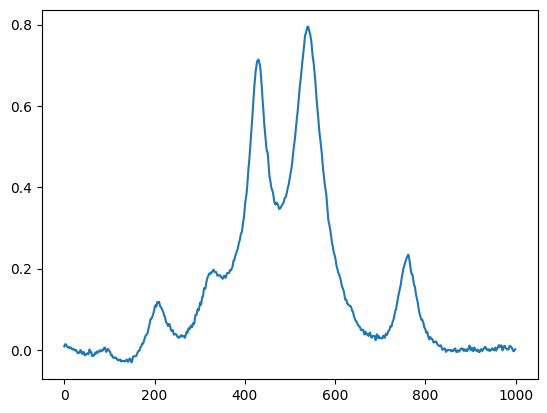

In [258]:
# test the function
i = 1
j = 1
file_name = f"exp_data/16_04/magnetic/I_.{i}A/F3_85_{j}.txt"
data = pd.read_csv(file_name, sep="\t", header=0)
# preprocess the data
y_data = data["Main in [V]"].values

# Fit the Gaussian model to the data
popt, y_data = fit_gaussian_with_interpolation(y_data, gap=50)

# check if the fit was successful
if popt is not None:
    # Generate x values for plotting the fitted curve
    x_fit = np.linspace(0, len(y_data) - 1, len(y_data))
    y_fit = gaussian(x_fit, *popt)

    # Plot the original data and the fitted curve
    plt.plot(y_data, label="Original Data")
    plt.plot(x_fit, y_fit, label="Fitted Gaussian", color="red")
    plt.legend()
    plt.show()
    plt.plot(y_data - y_fit)

In [259]:
# real data
x = np.empty((50, 1000))
y = np.empty((50, 1))
for i in range(1, 6):
    for j in range(1, 11):
        file_name = f"exp_data/16_04/magnetic/I_.{i}A/F3_85_{j}.txt"
        data = pd.read_csv(file_name, sep="\t", header=0)
        # preprocess the data
        x_data = data["Main in [V]"].values

        # Fit the Gaussian model to the data
        popt, x_data = fit_gaussian_with_interpolation(x_data, gap=50)
        x_arr = np.arange(1000)
        x_clean = x_data - gaussian(x_arr, *popt)
        x_clean = rescale_data(x_clean)
        x[10 * (i - 1) + j - 1] = x_clean
        y[10 * (i - 1) + j - 1] = i / 10

# Split the dataset into training and testing sets
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(
    x, y, test_size=0.2, random_state=42
)

# Create datasets and dataloaders for train and test sets
train_dataset = LorentzianDataset(X_train_real, y_train_real)
test_dataset = LorentzianDataset(X_test_real, y_test_real)
train_dataloader_r = DataLoader(train_dataset, batch_size=50, shuffle=True)
test_dataloader_r = DataLoader(test_dataset, batch_size=50, shuffle=True)
print(f"X_train shape: {X_train_real.shape}, y_train shape: {y_train_real.shape}")
print(f"X_test shape: {X_test_real.shape}, y_test shape: {y_test_real.shape}")

X_train shape: (40, 1000), y_train shape: (40, 1)
X_test shape: (10, 1000), y_test shape: (10, 1)


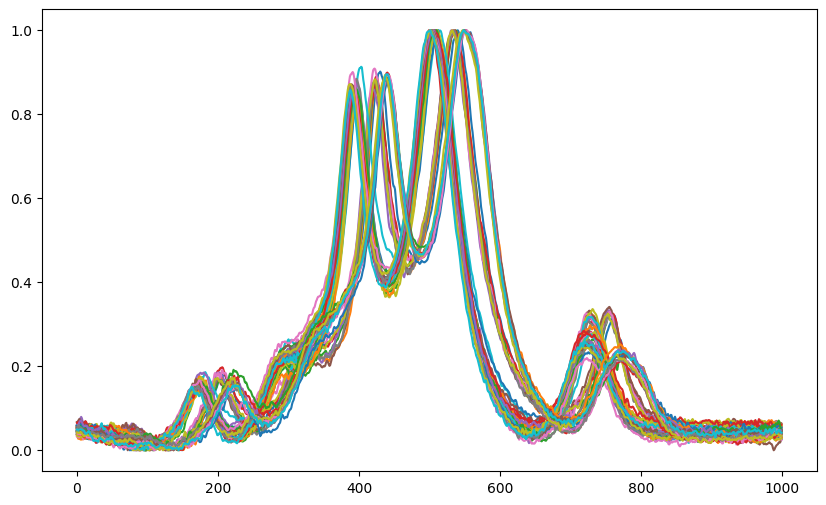

In [260]:
# plot all the data

plt.figure(figsize=(10, 6))
for i in range(50):
    plt.plot(x[i], label=f"Sample {i + 1}")

In [261]:
# SYNTHETIC DATASET CELL
def create_dataset(param, num_samples=1000, noise=0.01):
    x = np.arange(1000)
    y1 = (0.5 + noise * np.random.randn(num_samples) * 10) * (
        1 / (1 + ((x - (300 + param)) / 50) ** 2)
    ) + noise * np.random.randn(num_samples) * 10
    y2 = (0.5 + noise * np.random.randn(num_samples) * 10) * (
        1 / (1 + ((x - (700 - param)) / 50) ** 2)
    ) + noise * np.random.randn(num_samples) * 10
    y = y1 + y2
    return y


# create the dataset
x = np.empty((1000, 1000))
y = np.empty((1000, 1))
for i in range(10):
    for j in range(100):
        x[100 * i + j] = create_dataset(j, num_samples=1000)
        y[100 * i + j] = j

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    x, y, test_size=0.5, random_state=42
)

# Create datasets and dataloaders for train and test sets
train_dataset = LorentzianDataset(X_train, y_train)
test_dataset = LorentzianDataset(X_test, y_test)

train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=True)

print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")

X_train shape: (500, 1000), y_train shape: (500, 1)
X_test shape: (500, 1000), y_test shape: (500, 1)


In [262]:
class CNN1D_LinReg(nn.Module):
    # architecture may be overkill
    # for linear regression
    def __init__(self):
        super(CNN1D_LinReg, self).__init__()
        self.conv1 = nn.Conv1d(
            in_channels=1, out_channels=64, kernel_size=4, stride=1, padding=1
        )
        self.conv2 = nn.Conv1d(
            in_channels=64, out_channels=128, kernel_size=4, stride=1, padding=1
        )
        self.pool = nn.MaxPool1d(kernel_size=3, stride=2)  # Pooling size 3

        input_size = 1000  # New input size
        conv1_out = (input_size - 4 + 2) + 1  # Conv1 output size (padding=1)
        pool1_out = (conv1_out - 3) // 2 + 1  # Pool1 output size
        conv2_out = (pool1_out - 4 + 2) + 1  # Conv2 output size (padding=1)
        pool2_out = (conv2_out - 3) // 2 + 1  # Pool2 output size

        self.flattened_size = 128 * pool2_out

        self.fc1 = nn.Linear(
            self.flattened_size, 64
        )  # Adjust input size based on pooling
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # Flatten before FC layers
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x


# Instantiate the model
model = CNN1D_LinReg()
print(model)

CNN1D_LinReg(
  (conv1): Conv1d(1, 64, kernel_size=(4,), stride=(1,), padding=(1,))
  (conv2): Conv1d(64, 128, kernel_size=(4,), stride=(1,), padding=(1,))
  (pool): MaxPool1d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=31744, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=1, bias=True)
  (sigmoid): Sigmoid()
)


Epoch 1/500, Loss: 0.0704
Epoch 2/500, Loss: 3.2550
Epoch 3/500, Loss: 0.0721
Epoch 4/500, Loss: 0.1567
Epoch 5/500, Loss: 0.1518
Epoch 6/500, Loss: 0.1304
Epoch 7/500, Loss: 0.0865
Epoch 8/500, Loss: 0.0461
Epoch 9/500, Loss: 0.0267
Epoch 10/500, Loss: 0.0216
Epoch 11/500, Loss: 0.0234
Epoch 12/500, Loss: 0.0254
Epoch 13/500, Loss: 0.0285
Epoch 14/500, Loss: 0.0236
Epoch 15/500, Loss: 0.0211
Epoch 16/500, Loss: 0.0206
Epoch 17/500, Loss: 0.0209
Epoch 18/500, Loss: 0.0217
Epoch 19/500, Loss: 0.0224
Epoch 20/500, Loss: 0.0229
Epoch 21/500, Loss: 0.0229
Epoch 22/500, Loss: 0.0227
Epoch 23/500, Loss: 0.0222
Epoch 24/500, Loss: 0.0214
Epoch 25/500, Loss: 0.0207
Epoch 26/500, Loss: 0.0201
Epoch 27/500, Loss: 0.0198
Epoch 28/500, Loss: 0.0200
Epoch 29/500, Loss: 0.0203
Epoch 30/500, Loss: 0.0206
Epoch 31/500, Loss: 0.0204
Epoch 32/500, Loss: 0.0201
Epoch 33/500, Loss: 0.0196
Epoch 34/500, Loss: 0.0193
Epoch 35/500, Loss: 0.0192
Epoch 36/500, Loss: 0.0192
Epoch 37/500, Loss: 0.0192
Epoch 38/5

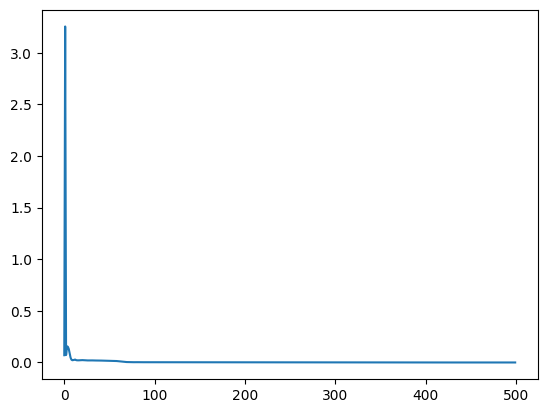

In [263]:
device = torch.device(
    "mps"
    if torch.backends.mps.is_available()
    else "cuda"
    if torch.cuda.is_available()
    else "cpu"
)
# train the model
model.to(device)
criterion = nn.MSELoss()  # Use Mean Squared Error for regression
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 500
losses = []
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for batch_idx, (inputs, labels) in enumerate(train_dataloader_r):
        # Reshape inputs to (batch_size, 1, sequence_length)
        inputs = inputs.unsqueeze(1).to(device)

        # Ensure labels are (batch_size, 1) and on the correct device
        labels = labels.view(-1, 1).to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
    epoch_loss = running_loss / len(train_dataloader_r)
    losses.append(epoch_loss)
    print(f"Epoch {epoch + 1}/{num_epochs}, Loss: {epoch_loss:.4f}")
plt.plot(losses)

Average Test Loss: 0.0006
R-squared (R2) Score: 0.9540


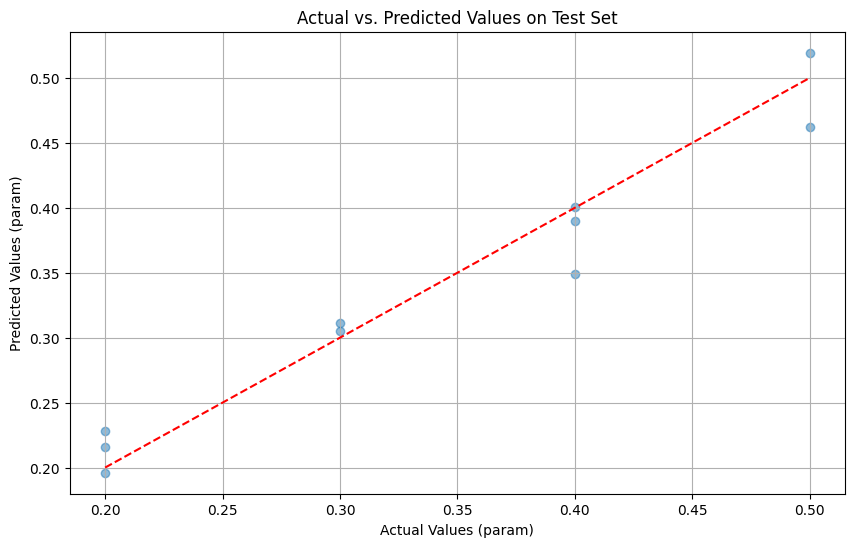

In [264]:
from sklearn.metrics import r2_score

# Evaluate the model on the test set
model.eval()  # Set the model to evaluation mode
test_loss = 0.0
all_preds = []
all_labels = []

with torch.no_grad():  # Disable gradient calculations
    for inputs, labels in test_dataloader_r:
        # Reshape inputs and move to device
        inputs = inputs.unsqueeze(1).to(device)
        # Reshape labels and move to device
        labels = labels.view(-1, 1).to(device)

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        test_loss += loss.item()
        all_preds.extend(outputs.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

avg_test_loss = test_loss / len(test_dataloader_r)
print(f"Average Test Loss: {avg_test_loss:.4f}")

# Convert lists to numpy arrays for plotting or further analysis
all_preds = np.array(all_preds).flatten()
all_labels = np.array(all_labels).flatten()

# Optional: Plot predictions vs actuals
plt.figure(figsize=(10, 6))
plt.scatter(all_labels, all_preds, alpha=0.5)
plt.plot(
    [min(all_labels), max(all_labels)], [min(all_labels), max(all_labels)], "r--"
)  # Identity line
plt.xlabel("Actual Values (param)")
plt.ylabel("Predicted Values (param)")
plt.title("Actual vs. Predicted Values on Test Set")
plt.grid(True)
# Calculate R2 score
r2 = r2_score(all_labels, all_preds)
print(f"R-squared (R2) Score: {r2:.4f}")

plt.show()

In [265]:
# run